# AI Challenge -- Part 2: Interpretability & Reporting

## 1. Introduction

In this challenge, I selected **ETT (Electricity Transformer Temperature)** dataset for training and testing the time series forecasting task. Then, in the first part, I implemented two transformer-based model:
- Informer (AAAI 2021 Best Paper)
- iTransformer (ICLR 2024)

Especially, in this task, I focus on *Multivariate Time-series Forecasting*, which is more close to the real-world scenarios.

## 2. Quantitaive Analysis

In this section, the performance of two transformer-based models will be measured with three evaluation metrics:
- Mean Square Error (MSE)
- Mean Absolute Error (MAE)
- Dynamic Time Warping (DTW)

The previous two metrics primarily evaluate the euclidean distance between the ground truth and predicted time series on a one-to-one basis along the time axis. Although they are popular evaluation metrics used in the research community, they still have limitations. For example, the amplitude of the first time series at time *T* is compared with the amplitude of the second time series at time *T*. This approach results in a poor comparison and similarity score, even if the two time series have similar shapes but are out of phase in time

DTW compares the amplitude of the first signal at time *T* with the amplitudes of the second signal at times *T+1*, *T-1*, *T+2*, and *T-2*. This ensures that signals with similar shapes but different phases do not receive low similarity scores.

### 2.1 Experimental Settings
The models are trained and evaulated independently based on four *.csv* files:
- ETTh1.csv
- ETTh2.csv
- ETTm1.csv
- ETTm2.csv

To have a fair and comprehensive comparison, we follow the hyperparameters and experimental settings based on the iTransformer paper (*e.g.,* three settings):
- *sequence_length: 96*, *label_length: 96*, *prediction_length: 96*
- *sequence_length: 96*, *label_length: 96*, *prediction_length: 192*
- *sequence_length: 96*, *label_length: 96*, *prediction_length: 336*

For each setting, we repeated the training with three different random seeds and calculated the quantitaive results.

### 2.2 Evaulation
After the training is finished, the prediction and ground-truth are stored in *pred.npy* and *real.npy* files. We will use these files to calculate the evaluation metrics.

In [20]:
import numpy as np 
from dtaidistance import dtw

"""
Please note: DTW will cost longer time, so I only select the previous 100 time series for calculating
"""

# sequence length and label length are fixed
seq_len, label_len = 96, 96
# we have three different 
pred_len = [96, 192, 336]
models = ["informer", "itransformer"]
data = ["ETTh1", "ETTh2", "ETTm1", "ETTm2"]

# calcuate metrics
def cal_metrics(data_path):
    preds, reals = [], []
    for seed_ in range(3):
        pred = np.load("{}/seed_{}/pred.npy".format(data_path, seed_+1))
        real = np.load("{}/seed_{}/real.npy".format(data_path, seed_+1))
        preds.append(pred)
        reals.append(real)
    # concatenate the results
    preds = np.concatenate(preds, axis=0)
    reals = np.concatenate(reals, axis=0)
    # start to calculate the metrics
    mse = np.mean((preds - reals)**2)
    mae = np.mean(np.abs(preds - reals))
    # dwt
    preds = preds.astype(np.double)
    reals = reals.astype(np.double)
    dtw_evals = []
    for i in range(preds.shape[0]):
        pred_ = preds[i].squeeze()
        real_ = reals[i].squeeze()
        for j in range(preds.shape[2]):
            val_ = dtw.distance_fast(pred_[:, j], real_[:, j], use_pruning=True)
            dtw_evals.append(val_)
    return mse, mae, np.mean(val_)

root_path = "checkpoints"
for model_ in models:
    for data_ in data:
        for pred_len_ in pred_len:
            data_path = "{}/{}/{}/M_{}_{}_{}".format(root_path, data_, model_, seq_len, label_len, pred_len_)
            mse, mae, dwt_val = cal_metrics(data_path)
            print("{}-{}-M_{}, MSE: {:.3f}, MAE: {:.3f}, DTW: {:.3f}".format(model_, data_, pred_len_, mse, mae, dwt_val))

informer-ETTh1-M_96, MSE: 0.950, MAE: 0.773, DWT: 14.060
informer-ETTh1-M_192, MSE: 1.004, MAE: 0.797, DWT: 16.008
informer-ETTh1-M_336, MSE: 1.227, MAE: 0.897, DWT: 10.722
informer-ETTh2-M_96, MSE: 4.359, MAE: 1.747, DWT: 14.526
informer-ETTh2-M_192, MSE: 6.767, MAE: 2.302, DWT: 23.869
informer-ETTh2-M_336, MSE: 4.478, MAE: 1.786, DWT: 18.506
informer-ETTm1-M_96, MSE: 0.558, MAE: 0.529, DWT: 3.809
informer-ETTm1-M_192, MSE: 0.745, MAE: 0.648, DWT: 9.130
informer-ETTm1-M_336, MSE: 0.928, MAE: 0.750, DWT: 12.202
informer-ETTm2-M_96, MSE: 0.360, MAE: 0.437, DWT: 8.410
informer-ETTm2-M_192, MSE: 0.781, MAE: 0.665, DWT: 14.522
informer-ETTm2-M_336, MSE: 1.067, MAE: 0.793, DWT: 16.619
itransformer-ETTh1-M_96, MSE: 0.388, MAE: 0.406, DWT: 1.874
itransformer-ETTh1-M_192, MSE: 0.441, MAE: 0.436, DWT: 2.327
itransformer-ETTh1-M_336, MSE: 0.487, MAE: 0.459, DWT: 1.740
itransformer-ETTh2-M_96, MSE: 0.301, MAE: 0.351, DWT: 1.981
itransformer-ETTh2-M_192, MSE: 0.382, MAE: 0.400, DWT: 4.010
itransfo

Based on the above statistics, iTransformer outperforms Informer across all metrics, datasets, and settings, especially in DTW metrics, which means iTransformer can predict time series with similar shape as the ground truth.

## 3. Qualitative Analysis (Visualization)

This section presents some visualization results of the predictions from both models (Focus on ETTm1 dataset). 

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline  

# will select the one for visualization
def visualization(data_path, index=None):
    pred = np.load("{}/pred.npy".format(data_path))
    real = np.load("{}/real.npy".format(data_path)) 
    pred_, real_ = pred[index], real[index]
    time_ = np.arange(pred_.shape[0])
    # start to plot the results
    data_topic = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
    model = data_path.split("/")[2]
    plt.figure(figsize=(15, 10))
    for data_id in range(len(data_topic)):
        plt.subplot(4, 2, data_id + 1)
        plt.plot(time_, real_[:, data_id], label="Groundtruth")
        plt.plot(time_, pred_[:, data_id], label="Prediction")
        plt.title("{} ({} Index: {})".format(data_topic[data_id], model, index))
        plt.legend(loc="lower right")
        plt.tight_layout()
    plt.show()

### 3.1 ETTm1 (predication_length=96)

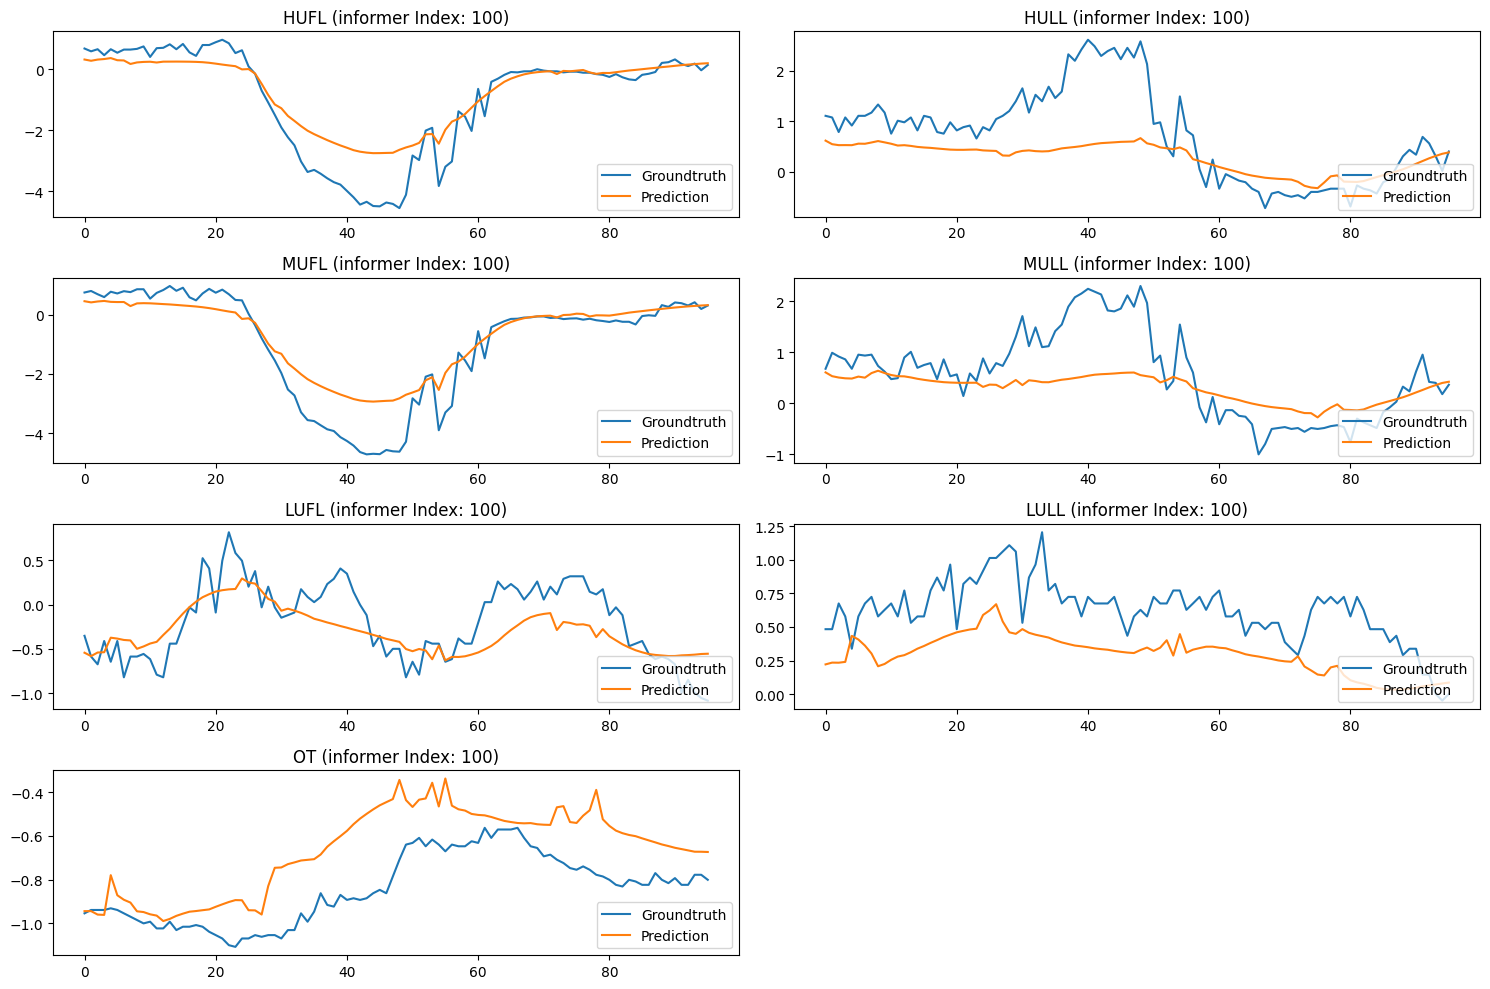

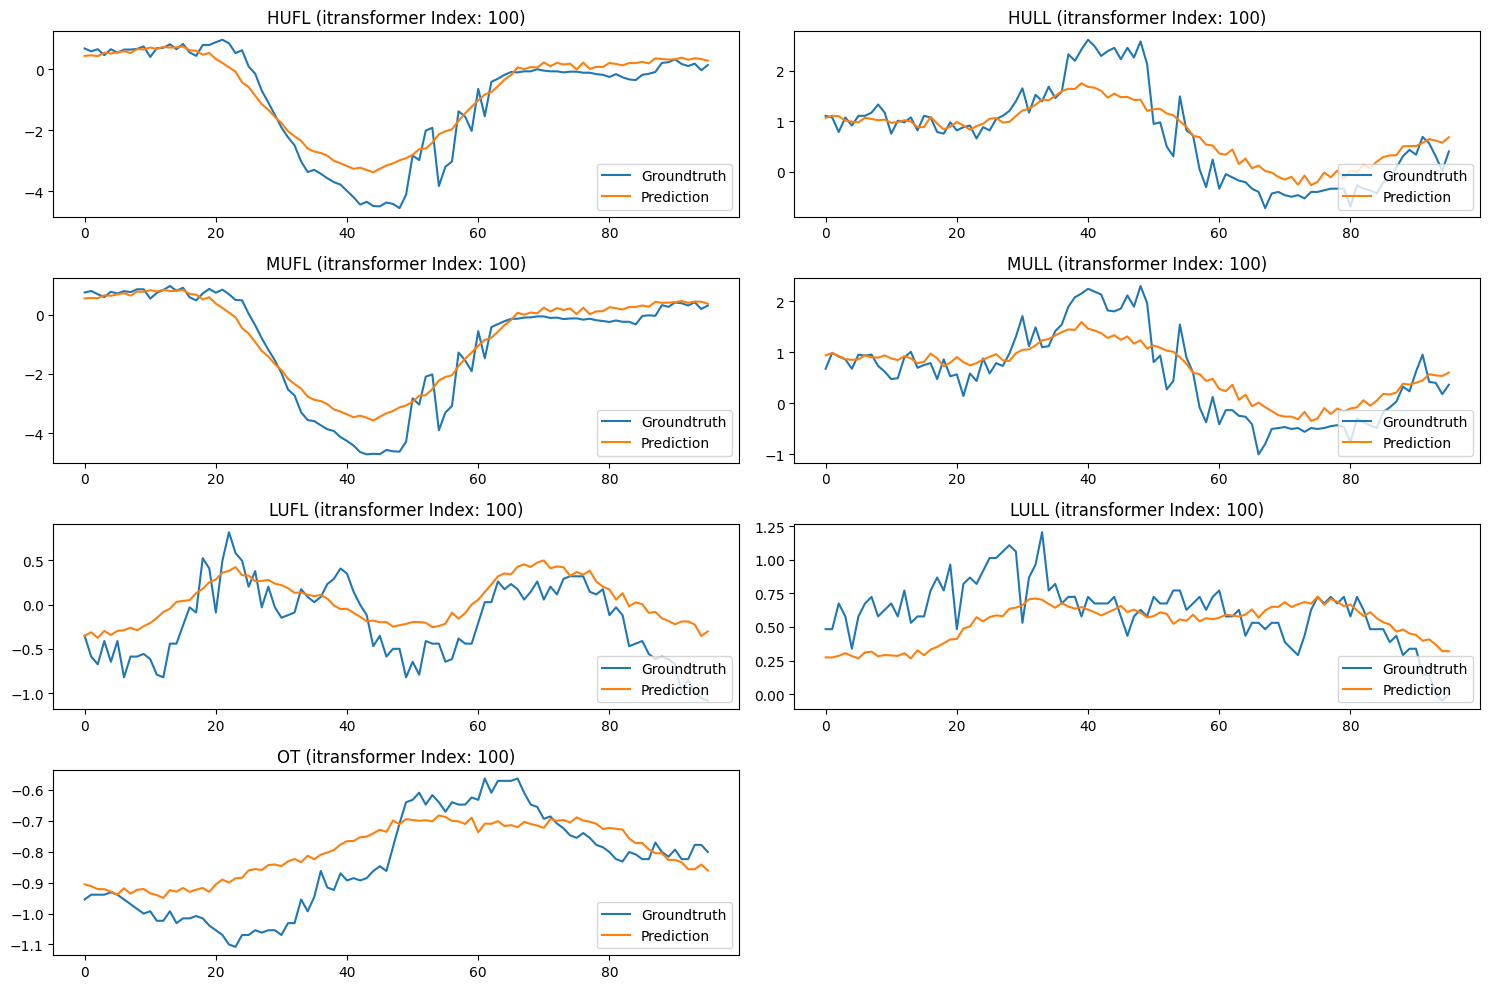

In [27]:
visualization("checkpoints/ETTm1/informer/M_96_96_96/seed_1", 100)
visualization("checkpoints/ETTm1/itransformer/M_96_96_96/seed_1", 100)

### 3.2 ETTm1 (predication_length=192)

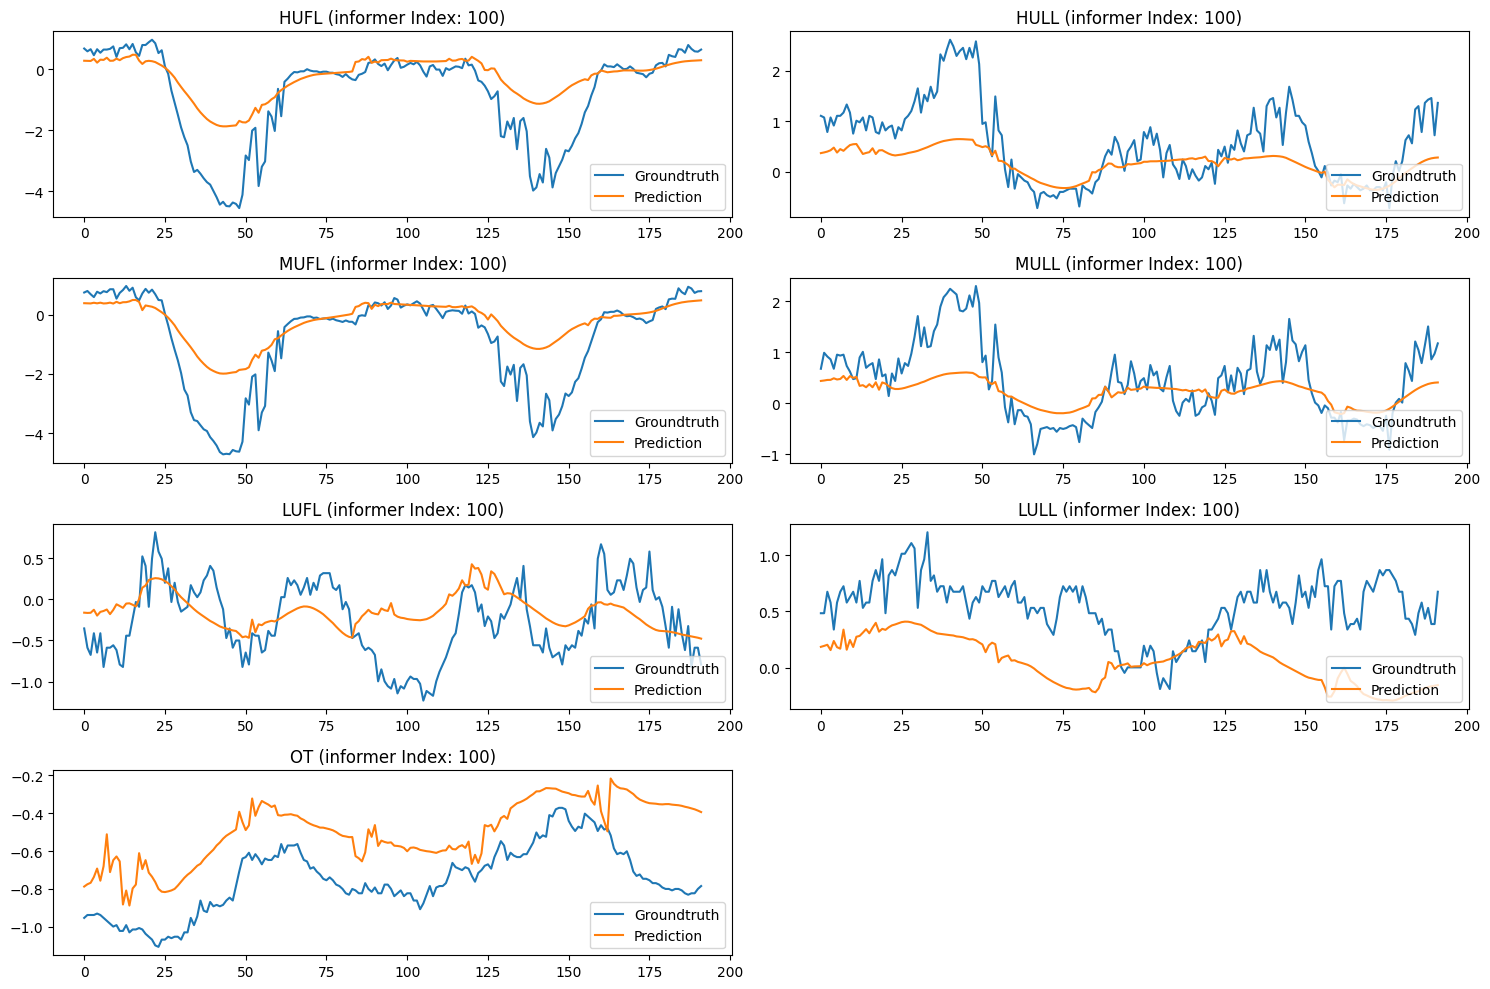

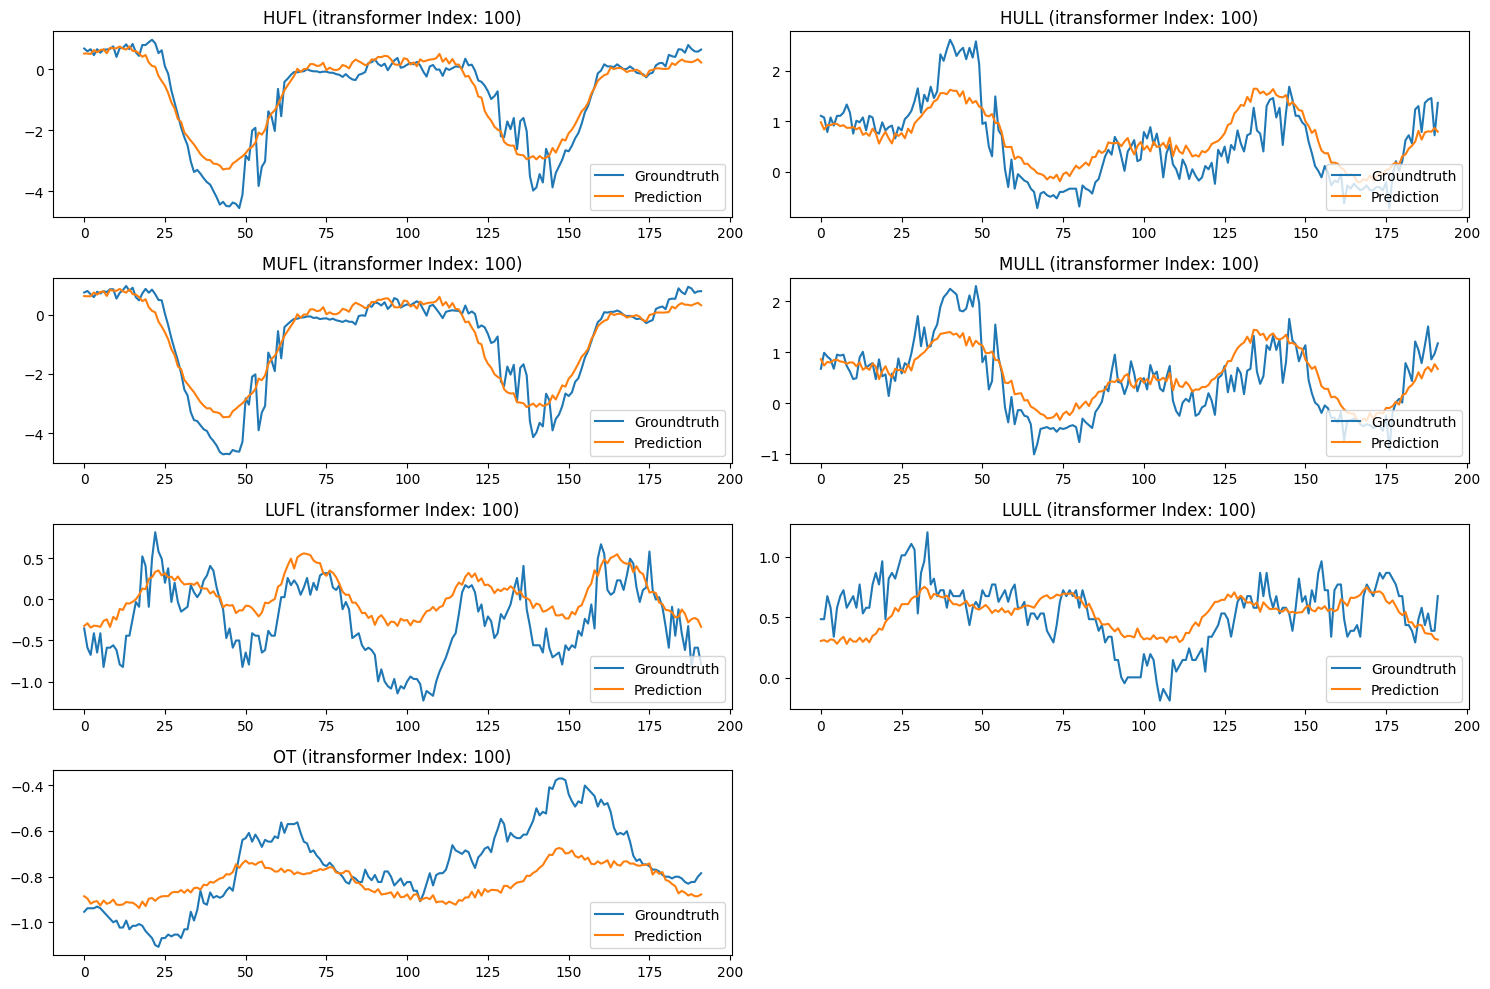

In [28]:
visualization("checkpoints/ETTm1/informer/M_96_96_192/seed_1", 100)
visualization("checkpoints/ETTm1/itransformer/M_96_96_192/seed_1", 100)

### 3.3 ETTm1 (predication_length=336)

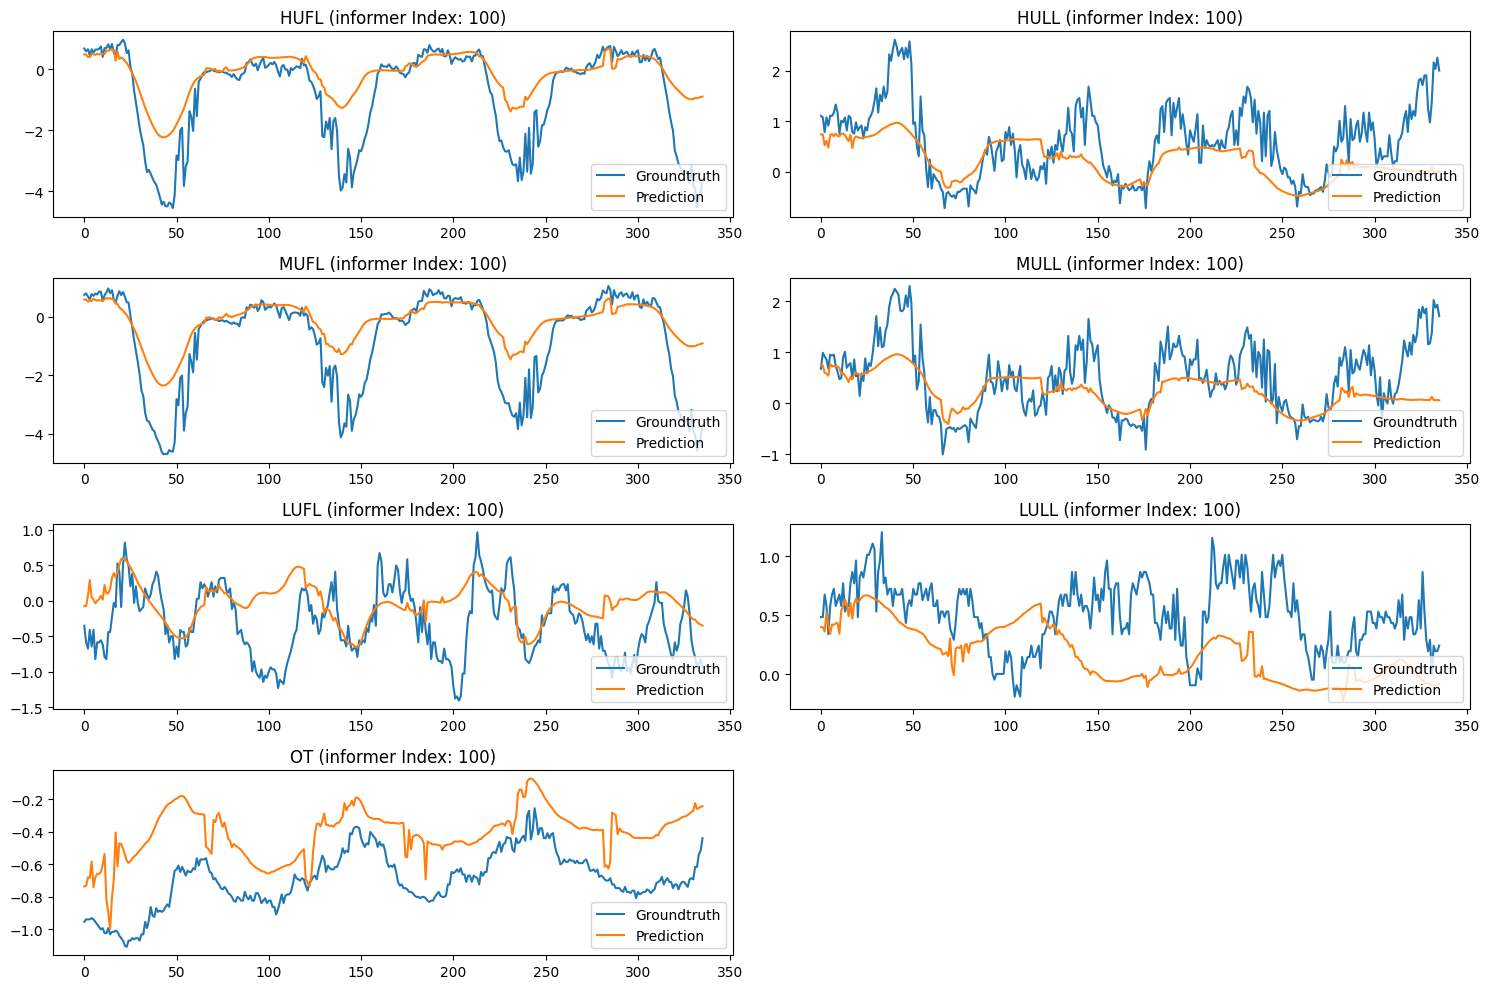

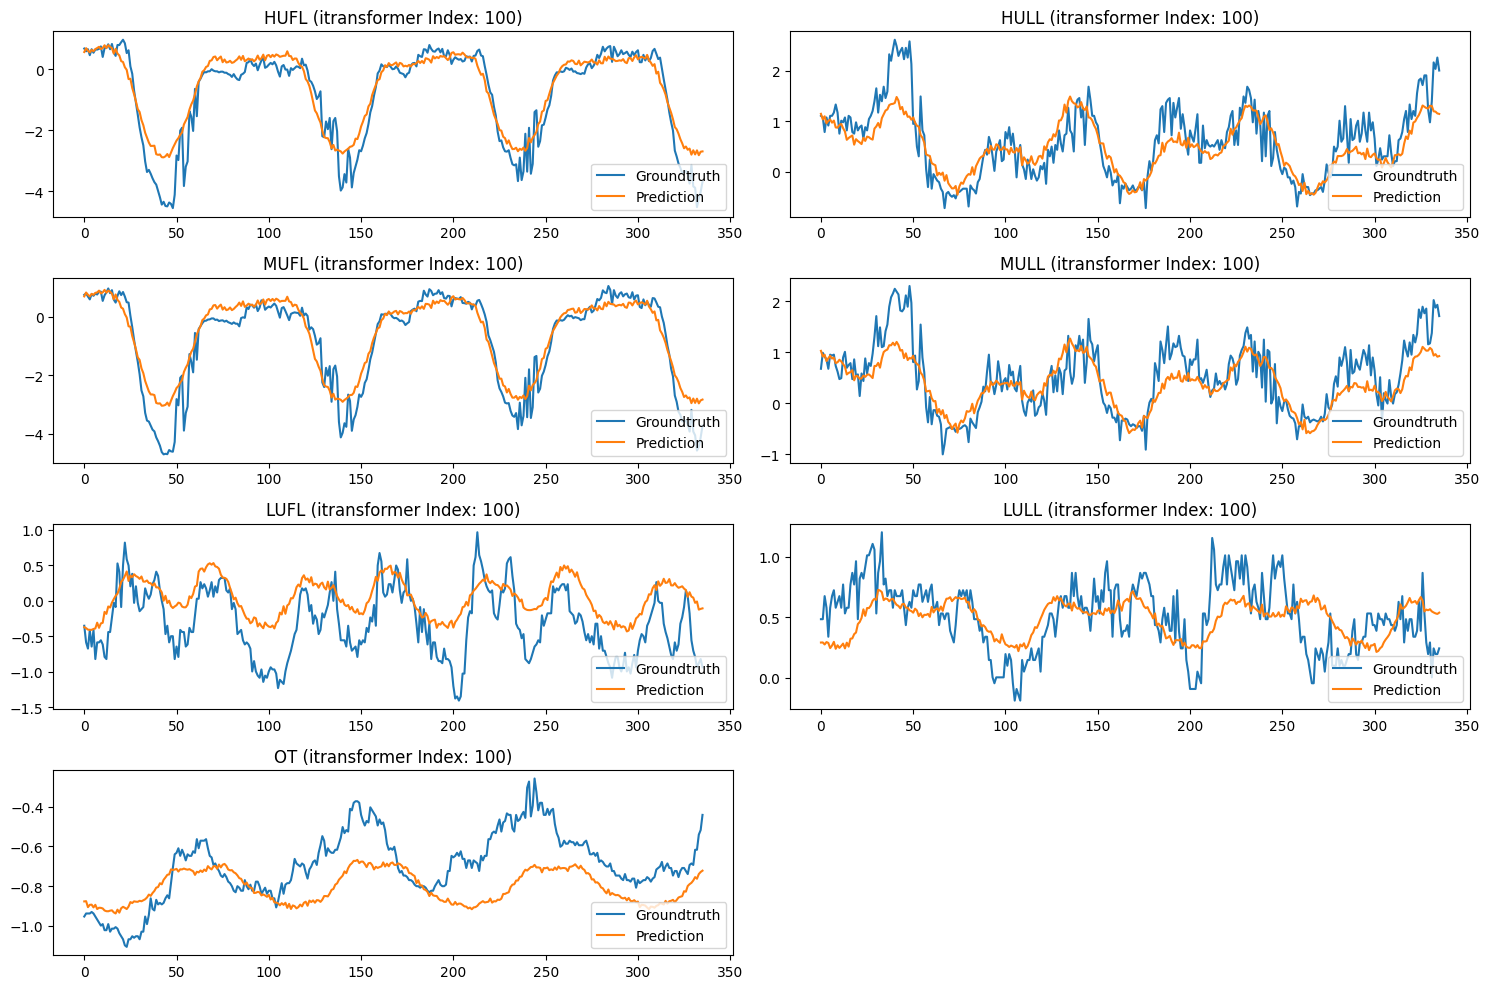

In [30]:
visualization("checkpoints/ETTm1/informer/M_96_96_336/seed_1", 100)
visualization("checkpoints/ETTm1/itransformer/M_96_96_336/seed_1", 100)

### 3.4 Bad Cases

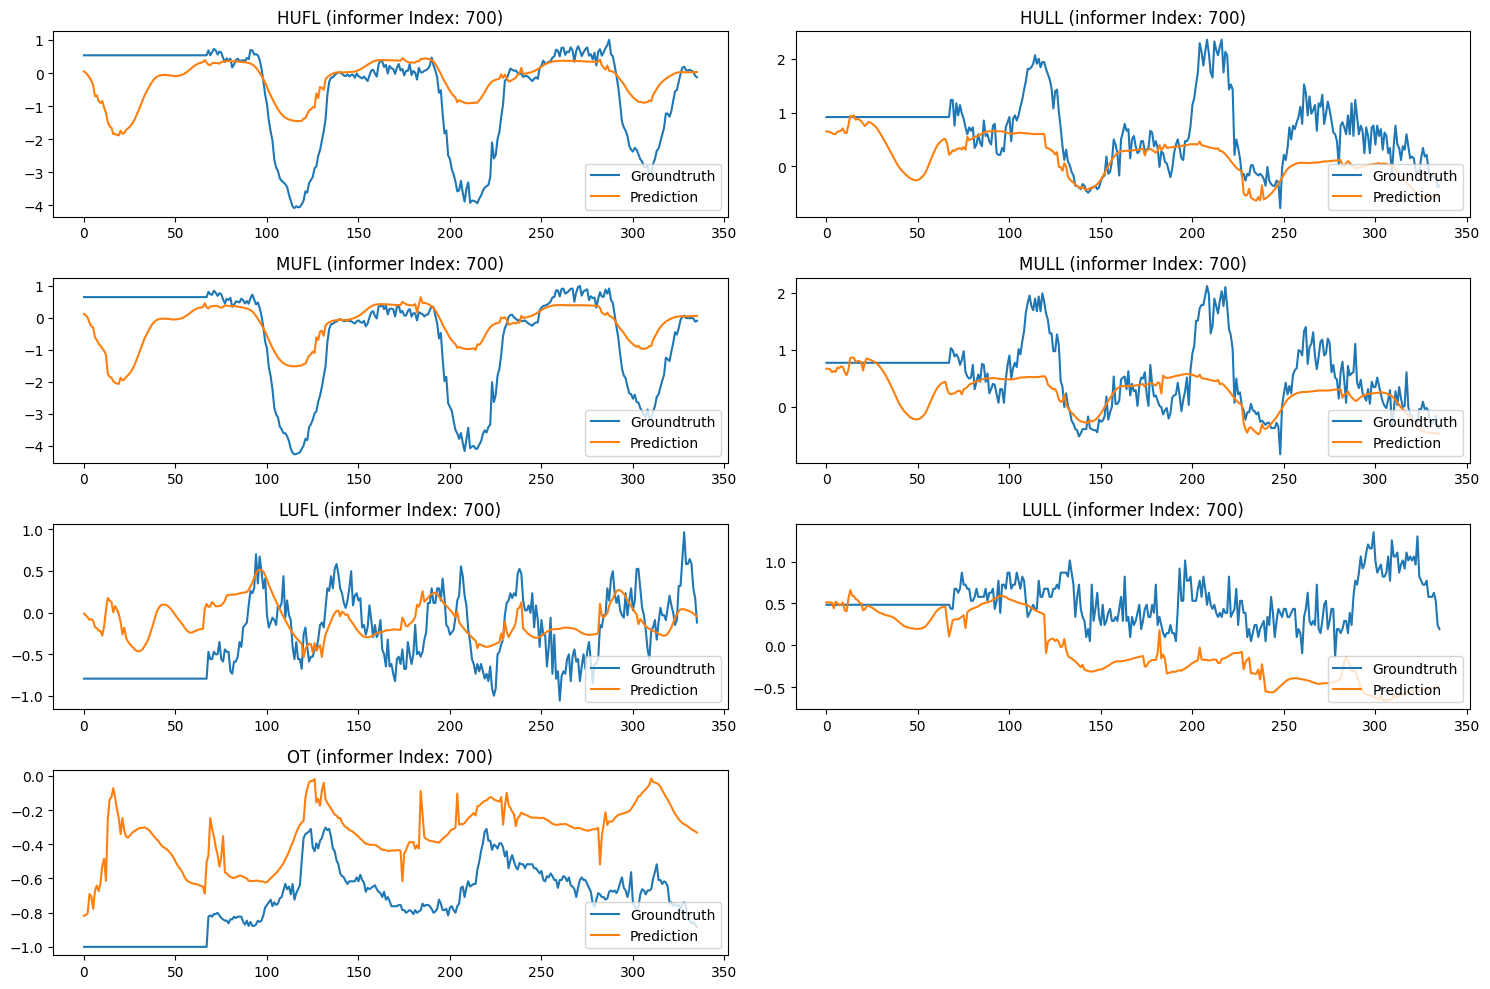

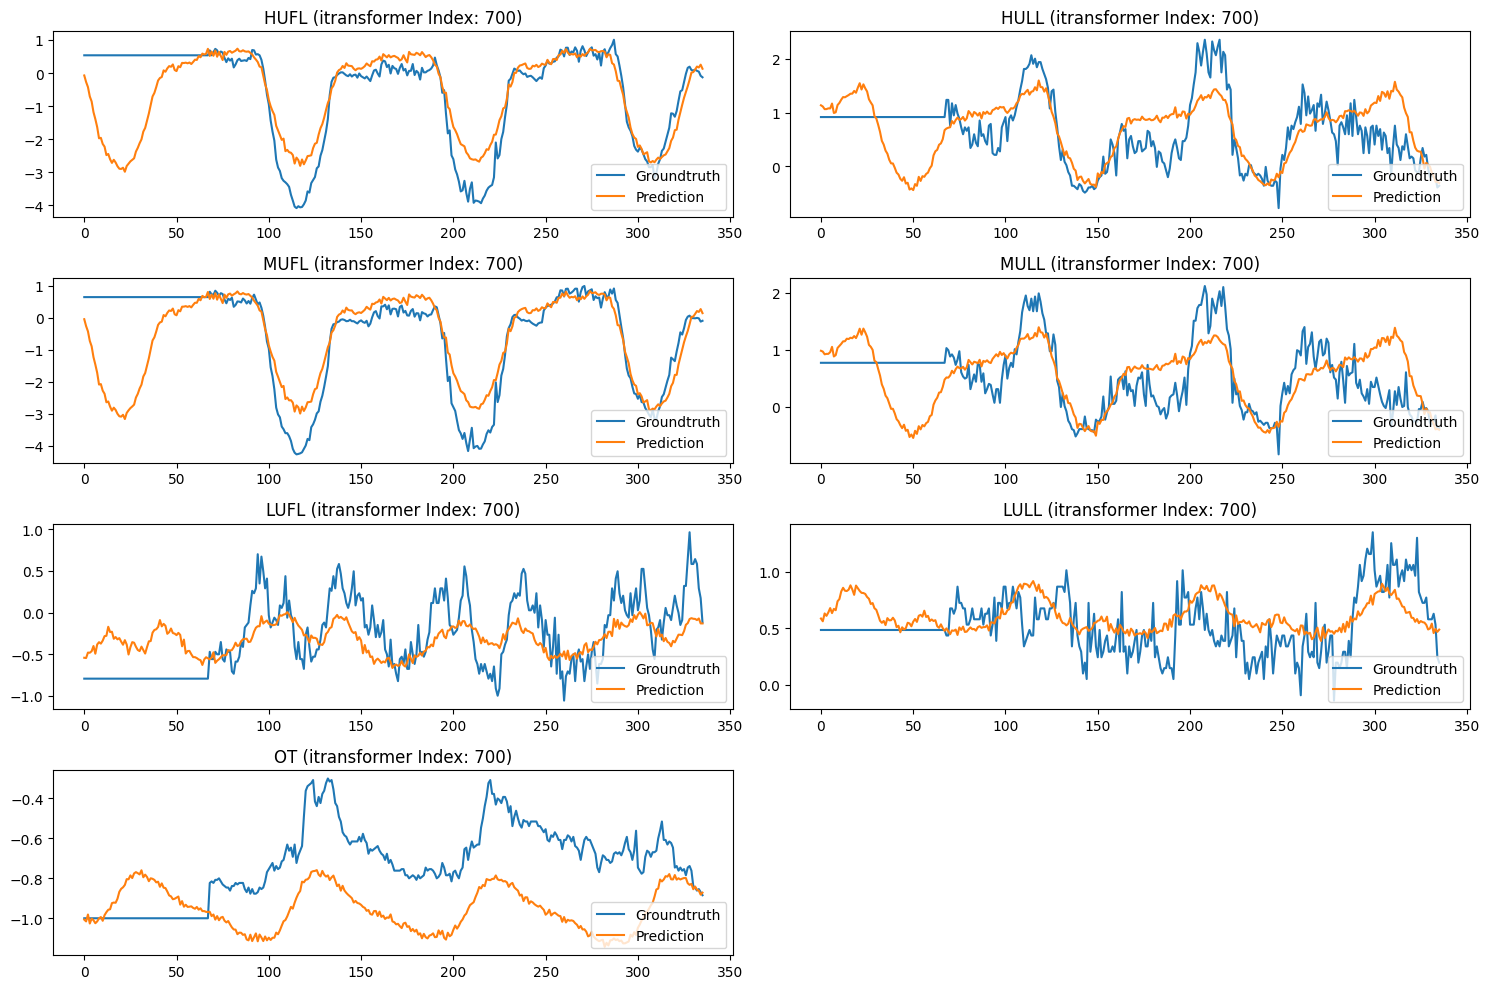

In [31]:

visualization("checkpoints/ETTm1/informer/M_96_96_336/seed_1", 700)
visualization("checkpoints/ETTm1/itransformer/M_96_96_336/seed_1", 700)

### 3.5 Analysis

Based on the above results, we can have following conclusions:
- Both informer and iTransformer can capture the trend of the long sequence time series.
- iTransformer can forcasting the time series data more accuracy than the informer.
- These two models are more suitable for periodic signal forcasting (see 3.4 -- bad case)

## 4. Conclusion
From the previous results, iTransformer is more suitable for long sequence time series forcasting tasks. Moreover, iTransformer just inverts the
structure of Transformer without modifying any native modules and it regards independent series as variate tokens to capture multivariate correlations by attention and utilize layer normalization and feed-forward networks to learn series representations.

In the future, I will do more analysis on the iTransformer to see if there's any places can be improved.